In [1]:
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme
themes = get_themes()
set_nb_theme(themes[1])

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
%matplotlib inline
%load_ext watermark
%load_ext autoreload 
%autoreload 2

from subprocess import call

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,recsys

Ethen 2017-04-02 18:11:16 

CPython 3.5.2
IPython 5.3.0

numpy 1.12.1
pandas 0.19.2
matplotlib 2.0.0
recsys 0.0.1


In [7]:
file_dir = 'ml-100k'
file_path = os.path.join(file_dir, 'u.data')
if not os.path.isdir(file_dir):
    call(['curl', '-O', 'http://files.grouplens.org/datasets/movielens/' + file_dir + '.zip'])
    call(['unzip', file_dir + '.zip'])

names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv(file_path, sep = '\t', names = names)
print('data dimension: \n', data.shape)
data.head()

data dimension: 
 (100000, 4)


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [8]:
from recsys.utils import create_matrix

In [9]:
user_col = 'user_id'
item_col = 'item_id'
rating_col = 'rating'
rating_threshold = 3
X, data = create_matrix(data, user_col, item_col, rating_col, 
                        rating_threshold = rating_threshold)
X

<943x1574 sparse matrix of type '<class 'numpy.int32'>'
	with 82520 stored elements in Compressed Sparse Row format>

In [10]:
from recsys.model_selection import create_train_test

In [11]:
X_train, X_test = create_train_test(X, test_size = 0.2, seed = 1234)
X_train

<943x1574 sparse matrix of type '<class 'numpy.int32'>'
	with 65641 stored elements in Compressed Sparse Row format>

In [12]:
from recsys.models import BPR

In [13]:
bpr_params = {
    'n_factors': 20,
    'learning_rate': 0.05,
    'n_iters': 10,
    'reg': 0.01,
    'n_batch_size': 2000 
}

bpr = BPR(**bpr_params)
bpr.fit(X_train)

BPR: 100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


BPR(learning_rate=0.05, n_batch_size=2000, n_factors=20, n_iters=10, reg=0.01,
  seed=1234, verbose=True)

In [60]:
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

def auc_score(model, ratings):
    auc = 0.0
    n_users, n_items = ratings.shape
    for user, row in tqdm(enumerate(ratings)):
        y_pred = model._predict_user(user)
        y_true = np.zeros(n_items, dtype = np.int32)
        y_true[row.indices] = 1
        auc += roc_auc_score(y_true, y_pred)

    auc /= n_users
    return auc

In [ ]:
from recsys.metrics import auc_score

In [61]:
print(auc_score(bpr, X_train))
print(auc_score(bpr, X_test))

943it [00:00, 1502.00it/s]
295it [00:00, 1461.56it/s]

0.947225771952


943it [00:00, 1466.74it/s]

0.898232382232


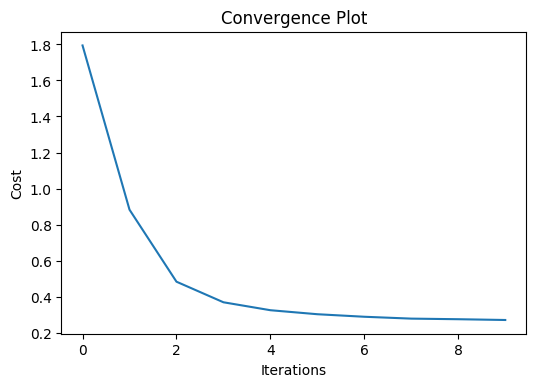

In [16]:
plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['font.size'] = 10

plt.plot(bpr.history)
plt.title('Convergence Plot')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [17]:
similar_items = bpr.get_similar_items(N = 5)
similar_items

array([[  49,  256,  403,  116,  221],
       [ 160,  582,  416,  227,  216],
       [ 408,  621,  538,  589,  780],
       ..., 
       [1548, 1337, 1339, 1555, 1522],
       [1543, 1405, 1486, 1388, 1535],
       [1442, 1541, 1532, 1545, 1502]], dtype=int32)

In [18]:
recommendation = bpr.recommend(X_train, N = 5)
recommendation

array([[  8, 355, 403, 490, 421],
       [317, 319,   8, 293, 123],
       [743, 331, 263, 867, 533],
       ..., 
       [126,   8,  49,  99, 403],
       [514, 306, 313, 293, 331],
       [  0, 117, 124, 591,  24]], dtype=int32)